In [ ]:
# Setting a device constant
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

t1 = pd.read_csv("Test1.csv")
t2 = pd.read_csv("Test2.csv")

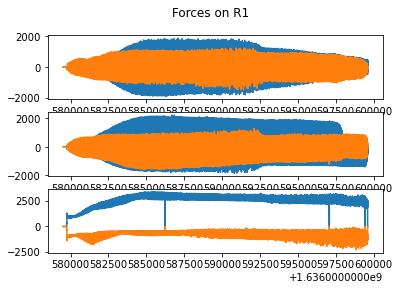

In [2]:
fig, axs = plt.subplots(3)
fig.suptitle('Forces on R1')
axs[0].plot(t1["t"], t1["fx_1"])
axs[1].plot(t1["t"], t1["fy_1"])
axs[2].plot(t1["t"], t1["fz_1"])
axs[0].plot(t1["t"], t1["fx_2"])
axs[1].plot(t1["t"], t1["fy_2"])
axs[2].plot(t1["t"], t1["fz_2"])

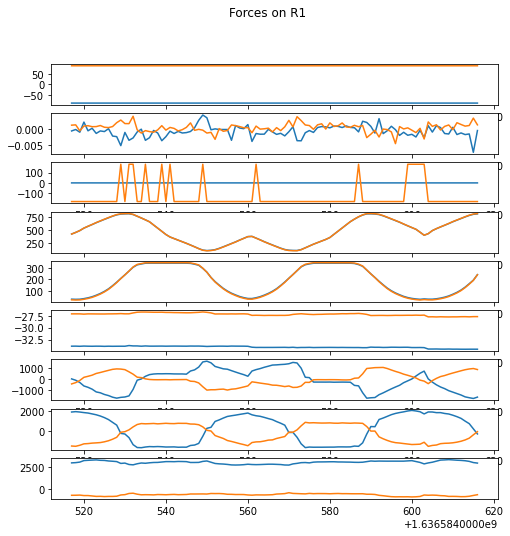

In [165]:
lb = 5000
ub = 5100

def exploratory_plot(lb, ub, df=t1):
    fig, axs = plt.subplots(9)
    fig.set_size_inches(8, 8)
    fig.suptitle('Forces on R1')

    axs[0].plot(df["t"][lb:ub], df["a_enc_1"][lb:ub])
    axs[1].plot(df["t"][lb:ub], df["b_enc_1"][lb:ub])
    axs[2].plot(df["t"][lb:ub], df["c_enc_1"][lb:ub])
    axs[0].plot(df["t"][lb:ub], df["a_enc_2"][lb:ub])
    axs[1].plot(df["t"][lb:ub], df["b_enc_2"][lb:ub])
    axs[2].plot(df["t"][lb:ub], df["c_enc_2"][lb:ub])

    axs[3].plot(df["t"][lb:ub], df["x_enc_1"][lb:ub])
    axs[4].plot(df["t"][lb:ub], df["y_enc_1"][lb:ub])
    axs[5].plot(df["t"][lb:ub], df["z_enc_1"][lb:ub])
    axs[3].plot(df["t"][lb:ub], df["x_enc_2"][lb:ub])
    axs[4].plot(df["t"][lb:ub], df["y_enc_2"][lb:ub])
    axs[5].plot(df["t"][lb:ub], df["z_enc_2"][lb:ub])

    axs[6].plot(df["t"][lb:ub], df["fx_1"][lb:ub])
    axs[7].plot(df["t"][lb:ub], df["fy_1"][lb:ub])
    axs[8].plot(df["t"][lb:ub], df["fz_1"][lb:ub])
    axs[6].plot(df["t"][lb:ub], df["fx_2"][lb:ub])
    axs[7].plot(df["t"][lb:ub], df["fy_2"][lb:ub])
    axs[8].plot(df["t"][lb:ub], df["fz_2"][lb:ub])

    if "pred_fx_1" in df.columns:
        axs[6].plot(df["t"][lb:ub], df["pred_fx_1"][lb:ub])
        axs[7].plot(df["t"][lb:ub], df["pred_fy_1"][lb:ub])
        axs[8].plot(df["t"][lb:ub], df["pred_fz_1"][lb:ub])
        axs[6].plot(df["t"][lb:ub], df["pred_fx_2"][lb:ub])
        axs[7].plot(df["t"][lb:ub], df["pred_fy_2"][lb:ub])
        axs[8].plot(df["t"][lb:ub], df["pred_fz_2"][lb:ub])

exploratory_plot(5000,5100)

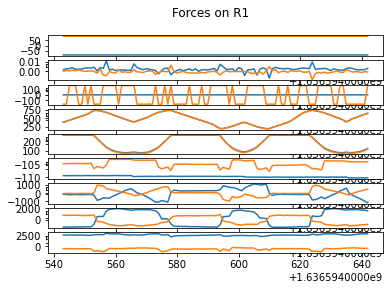

In [4]:
exploratory_plot(15025,15125)

# Torch Data Loading

In [ ]:
# Scaling code
import numpy as np

def scale_values(df):
    # somewhat arbitrary values obtained by inspecting standard deviations
    df["a_enc_1"] = df["a_enc_1"]/180.0
    df["b_enc_1"] = df["b_enc_1"]/180.0
    df["c_enc_1"] = df["c_enc_1"]/180.0
    df["a_enc_2"] = df["a_enc_2"]/180.0
    df["b_enc_2"] = df["b_enc_2"]/180.0
    df["c_enc_2"] = df["c_enc_2"]/180.0

    df["x_enc_1"] = df["x_enc_1"]/100.0
    df["y_enc_1"] = df["y_enc_1"]/100.0
    df["z_enc_1"] = df["z_enc_1"]/100.0
    df["x_enc_2"] = df["x_enc_2"]/100.0
    df["y_enc_2"] = df["y_enc_2"]/100.0
    df["z_enc_2"] = df["z_enc_2"]/100.0

    # output scaling
    response_columns = ["fx_1", "fx_2", "fy_1", "fy_2", "fz_1", "fz_2"]
    for c in response_columns:
        df[c] = df[c] / 250.0
    return df

In [152]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class PathToForceSegments(Dataset):
    """
    Dataset to provide the previous :lookback_window: number of observations from the dataset and the time of the next result
    """
    def __init__(self, csv_paths, window_size=50):
        dataframes = [pd.read_csv(path) for path in csv_paths]
        self.dataframe = pd.concat(dataframes)
        self.window_size = window_size
        self.dataframe = scale_values(self.dataframe)
        self.data = []
        for i in tqdm(range(len(self.dataframe) - window_size + 1)):
            self.data.append(self.preprocess(i))

    def __len__(self):
        return len(self.dataframe) - self.window_size + 1

    def preprocess(self, idx):
        target_idx = idx+self.window_size
        past_measurements = self.dataframe[idx:target_idx]
        r1_enc = past_measurements[["a_enc_1", "b_enc_1", "c_enc_1", "x_enc_1", "y_enc_1", "z_enc_1"]]
        r2_enc = past_measurements[["a_enc_2", "b_enc_2", "c_enc_2", "x_enc_2", "y_enc_2", "z_enc_2"]]
        target_r1_f = past_measurements[["fx_1", "fy_1", "fz_1"]]
        target_r2_f = past_measurements[["fx_2", "fy_2", "fz_2"]]

        result = {
            "t": self.dataframe.iloc[target_idx-1]["t"],
            "r1_enc": np.asarray(r1_enc).astype(np.float32),
            "r2_enc": np.asarray(r2_enc).astype(np.float32),
            "target_r1_f": np.asarray(target_r1_f).astype(np.float32),
            "target_r2_f": np.asarray(target_r2_f).astype(np.float32),
        }
        return result

    def __getitem__(self, idx):
        return self.data[idx]


## Model Definitions

In [131]:
import torch
from torch import nn

class SimpleModel(nn.Module):
    """
    Linear model mapping [batch, window_size, 12] inputs to [batch, window_size, 6] outputs

    Direct linear regression on windows of encoder values representing a tool path
    """
    def __init__(self, window_size=50):
        super().__init__()
        self.linear_layer = nn.Linear(12*window_size,6*window_size)

    def forward(self, input_dict):
        past = torch.cat(
            [
                input_dict["r1_enc"],
                input_dict["r2_enc"],
            ],
            dim=-1
        )
        flattened = past.flatten(start_dim=1)
        prediction = self.linear_layer(flattened)
        result = torch.reshape(prediction, [past.size(0), past.size(1), 6])
        return result


class RecurrentModel(nn.Module):
    """
    Model using Bidirectional LSTM to generate features for each position

    The idea here is to introduce some non-linearity in the features generated by the measurements.

    The LSTM is somewhat arbitrary, other options would be something like a Transformer.  

    The bidirectional model is chosen with the idea that the prediction at step t might be better informed by a notion of 
    the larger plan by looking at where the robots are heading to at time t+1,...,t+n.
    """
    def __init__(self, hidden_size=16, window_size=50):
        super().__init__()
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, bidirectional=True)
        initial_blocks = [
            nn.Linear(12,hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size)
        ]
        self.initial_blocks = nn.Sequential(*initial_blocks)

        self.linear_layer = nn.Linear(2*hidden_size*window_size,6*window_size)

    def forward(self, input_dict):
        past = torch.cat(
            [
                input_dict["r1_enc"],
                input_dict["r2_enc"],
            ],
            dim=-1
        )
        past = self.initial_blocks(past)
        # print(past.shape)
        encoded_path = torch.transpose(past,0,1)
        encoded_path, _ = self.lstm(encoded_path)
        encoded_path = torch.transpose(encoded_path,0,1)

        flattened = encoded_path.flatten(start_dim=1)
        prediction = self.linear_layer(flattened)
        result = torch.reshape(prediction, [past.size(0), past.size(1), 6])
        return result


class Loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.MSELoss() # 

    def forward(self, output, sample):        
        label = torch.cat([sample["target_r1_f"], sample["target_r2_f"]], dim=-1)
        return self.loss(output, label)


In [123]:
from time import time
from torch import optim
import torch

def train(train_dataloader, val_dataloader, hidden_size=32, epochs=100, lr=0.001, model_type="simple"):
    """
    Simple Training Loop
    """
    loss_module = Loss().to(DEVICE)
    # regularizer = L1OutputRegularization().to(device)
    if model_type == "simple":
        model = SimpleModel().to(DEVICE)
    else:
        model = RecurrentModel(hidden_size=hidden_size).to(DEVICE)
    optimizer = optim.RMSprop(model.parameters(), lr)

    running_loss = 0.0
    val_running_loss = 0.0
    print("Start Training Loop")
    for epoch in range(epochs):
        
        counter = 0
        for i, data in enumerate(train_dataloader):
            data = {k:v.to(DEVICE) for k,v in data.items()}
            out = model(data)
            loss = loss_module(out, data)
            # l1_penalty = regularizer(out)
            total_loss = loss
            total_loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # running_l1_loss += l1_penalty.item()
            counter += 1

        for i, data in enumerate(val_dataloader):
            data = {k:v.to(DEVICE) for k,v in data.items()}
            out = model(data)
            loss = loss_module(out, data)
            val_running_loss += loss.item()
            counter += 1

        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / counter:.3f}, val_loss: {val_running_loss / counter:.3f}')

        running_loss = 0.0
        val_running_loss = 0.0
    return model


## Setup the Datasets

In [13]:
segment_ds0 = PathToForceSegments(["Test1.csv"], window_size=50)
segment_ds1 = PathToForceSegments(["Test2.csv"], window_size=50)
segment_ds = torch.utils.data.ConcatDataset([segment_ds0, segment_ds1])
segment_val_ds = PathToForceSegments(["Test4.csv"], window_size=50)

## Train the Simple Model

In [124]:
train_dataloader = DataLoader(segment_ds, batch_size=512, shuffle=True)
val_dataloader = DataLoader(segment_val_ds, batch_size=512, shuffle=True)
model = train(train_dataloader, val_dataloader, lr=0.0005, epochs=100)
torch.save(model.state_dict(), "simple.pth")

cuda:1
Start Training Loop
[1,    57] loss: 4.771, val_loss: 4.558
[2,    57] loss: 2.852, val_loss: 3.373
[3,    57] loss: 2.410, val_loss: 3.252
[4,    57] loss: 2.257, val_loss: 3.095
[5,    57] loss: 2.150, val_loss: 2.686
[6,    57] loss: 2.044, val_loss: 2.390
[7,    57] loss: 1.970, val_loss: 2.642
[8,    57] loss: 1.920, val_loss: 2.428
[9,    57] loss: 1.881, val_loss: 2.160
[10,    57] loss: 1.843, val_loss: 2.258
[11,    57] loss: 1.807, val_loss: 2.157
[12,    57] loss: 1.770, val_loss: 2.058
[13,    57] loss: 1.738, val_loss: 2.065
[14,    57] loss: 1.711, val_loss: 2.100
[15,    57] loss: 1.688, val_loss: 2.138
[16,    57] loss: 1.670, val_loss: 1.854
[17,    57] loss: 1.638, val_loss: 1.954
[18,    57] loss: 1.618, val_loss: 1.977
[19,    57] loss: 1.596, val_loss: 1.833
[20,    57] loss: 1.586, val_loss: 1.912
[21,    57] loss: 1.591, val_loss: 1.861
[22,    57] loss: 1.572, val_loss: 1.820
[23,    57] loss: 1.567, val_loss: 1.793
[24,    57] loss: 1.559, val_loss: 1.88

### Simple Model Notes

In this particular case, the direct linear regression shows reasonable generalization with validation losses decreasing alongside the when trained with RMSProp.  If this model did overfit, regularization could be added to the regression weights to cope with the fact that the number of parameters of the model are greater than the number of samples.

## Train the LSTM Model

In [132]:
train_dataloader = DataLoader(segment_ds, batch_size=512, shuffle=True)
val_dataloader = DataLoader(segment_val_ds, batch_size=512, shuffle=True)
lstm_model = train(train_dataloader, val_dataloader, lr=0.0005, hidden_size=32, epochs=100, model_type="lstm")
torch.save(lstm_model.state_dict(), "lstm_model.pth")

cuda:1
Start Training Loop
[1,    57] loss: 2.950, val_loss: 3.518
[2,    57] loss: 1.329, val_loss: 3.978
[3,    57] loss: 0.892, val_loss: 3.174
[4,    57] loss: 0.712, val_loss: 4.097
[5,    57] loss: 0.608, val_loss: 5.045
[6,    57] loss: 0.538, val_loss: 5.907
[7,    57] loss: 0.494, val_loss: 7.337
[8,    57] loss: 0.461, val_loss: 8.667
[9,    57] loss: 0.433, val_loss: 10.009
[10,    57] loss: 0.415, val_loss: 10.778
[11,    57] loss: 0.400, val_loss: 11.663
[12,    57] loss: 0.392, val_loss: 13.803
[13,    57] loss: 0.385, val_loss: 13.984
[14,    57] loss: 0.383, val_loss: 12.562
[15,    57] loss: 0.377, val_loss: 14.073
[16,    57] loss: 0.368, val_loss: 11.400
[17,    57] loss: 0.355, val_loss: 12.663
[18,    57] loss: 0.348, val_loss: 12.663
[19,    57] loss: 0.343, val_loss: 12.365
[20,    57] loss: 0.344, val_loss: 11.377
[21,    57] loss: 0.339, val_loss: 9.982
[22,    57] loss: 0.329, val_loss: 9.894
[23,    57] loss: 0.327, val_loss: 9.806
[24,    57] loss: 0.320, va

## LSTM Model Notes

The LSTM based model is quick to overfit with validation losses rapidly diverging into non-sensical territory.  In this particular scenario, the simpler linear model is clearly preferable between the two.  However, in a situation with much more data a more expressive model (such as the LSTM based model) may prove to be more accurate.

## Model Inspection + Value

In [135]:
def plot_segment(idx=0, ds=segment_ds, model=None):
    fig, axs = plt.subplots(9)
    fig.set_size_inches(8, 8)
    fig.suptitle('Model Output Inspection')
    time_axis = list(range(ds[idx]["r1_enc"].shape[0]))

    if model is not None:
        input = {k: torch.as_tensor(np.expand_dims(v, axis=0)).float().to(DEVICE) for k,v in ds[idx].items()}
        out = model(input)
        out = out.cpu().detach().numpy()
        # out = np.sign(out)*np.square(out)
        predicted_r1_f = out[0,:,0:3]
        predicted_r2_f = out[0,:,3:]


    for i in range(9):
        axs[i].set_xlim(-1,51)
    for i in range(6):
        axs[i].plot(time_axis, ds[idx]["r1_enc"][:,i])
        axs[i].plot(time_axis, ds[idx]["r2_enc"][:,i])
    for i in range(3):
        axs[i+6].plot(time_axis, ds[idx]["target_r1_f"][:,i])
        axs[i+6].plot(time_axis, ds[idx]["target_r2_f"][:,i])
        if model is not None:
            axs[i+6].plot(time_axis, predicted_r1_f[:,i])
            axs[i+6].plot(time_axis, predicted_r2_f[:,i])

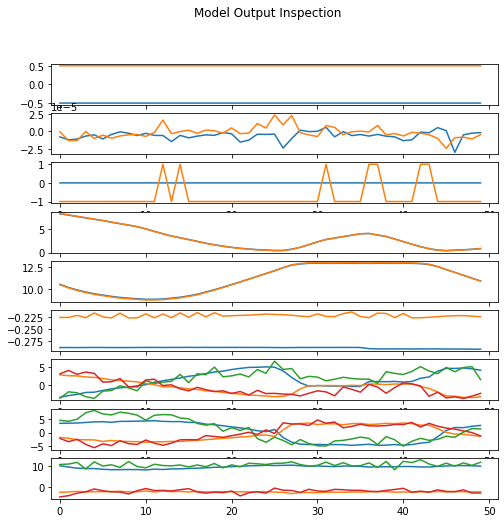

In [136]:
# Get predictions from the simple model on the validation set
plot_segment(5100, ds=segment_val_ds, model=model)

## Simple Model Qualitative Notes

The simple model seems to roughly capture the overall forces for randomly selected segments of 50 from a visual inspection, though with fairly large errors.

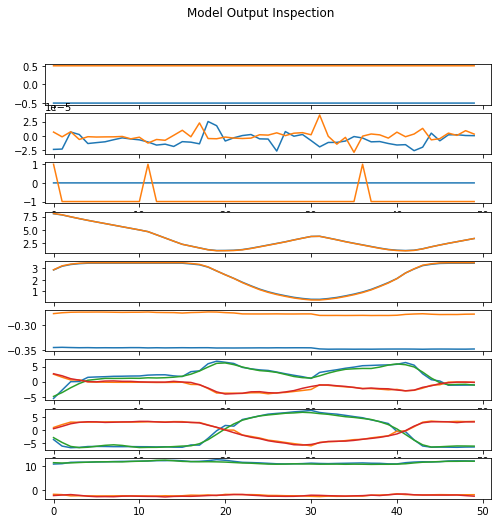

In [138]:
# Plotting against a sample from the training set
plot_segment(5100, ds=segment_ds0, model=lstm_model)

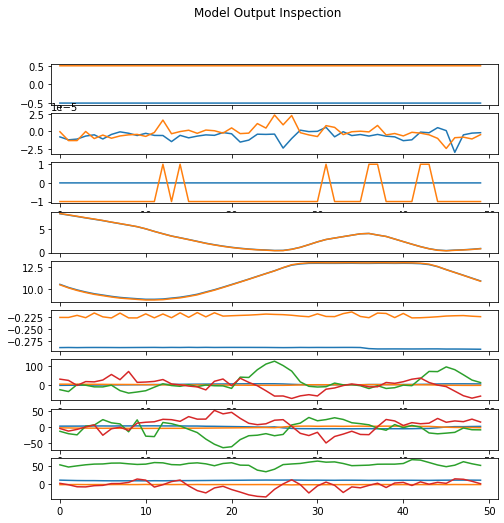

In [137]:
plot_segment(5100, ds=segment_val_ds, model=lstm_model)

## LSTM Notes
As noted above, the LSTM model is extremely overfit.  Hence, the plots on training data look great and useless on the validation data (looking at the last 3 rows).  

# Predicting Full Tool Paths

When predicting full tool paths, one possibility for generating predictions is to predict on overlapping windows and combining the outputs.  A number of options (e.g. mean, median, or other filters) could be evaluated to see if it improves error rates.  This strategy could be applied to any model that has predictions that change based on the window provided.

In [171]:
def get_estimates(x):
    output = [[] for _ in range(len(x) + 49)]
    for i, entry in tqdm(enumerate(x)):
        for j, val in enumerate(entry[0]):
            try:
                output[i+j].append(val)
            except:
                print(i+j)
    return output

def full_inference(csv_path, model):
    print("Preprocessing Data")
    ds = PathToForceSegments([csv_path], window_size=50)
    predictions = []
    for i in tqdm(range(len(ds))):
        input = {k: torch.as_tensor(np.expand_dims(v, axis=0)).float().to(DEVICE) for k,v in ds[i].items()}
        out = model(input)
        out = out.cpu().detach().numpy()
        predictions.append(out)
    
    grouped_estimates = get_estimates(predictions)
    smoothed_estimates = [np.mean(x,axis=0).tolist() for x in grouped_estimates]

    # Individual estimates do not exactly correspond to fully partitioned predictions on disjoint segments of the toolpath
    # However, these provide a quick illustration of using estimate
    individual_estimates = [x[0] for x in grouped_estimates]
    pred_df = pd.DataFrame(smoothed_estimates, columns=["pred_fx_1", "pred_fy_1", "pred_fz_1", "pred_fx_2", "pred_fy_2", "pred_fz_2"])
    pred_individual_df = pd.DataFrame(individual_estimates, columns=["ind_pred_fx_1", "ind_pred_fy_1", "ind_pred_fz_1", "ind_pred_fx_2", "ind_pred_fy_2", "ind_pred_fz_2"])
    base_df = pd.read_csv(csv_path)
    scale_values(base_df)
    final_df = pd.concat([base_df, pred_df, pred_individual_df], axis=1)
    
    return final_df
    

linear_predicted_path = full_inference("Test4.csv", model)

Preprocessing Data


100%|██████████| 28938/28938 [00:12<00:00, 2397.07it/s]
28938it [00:00, 55907.75it/s]


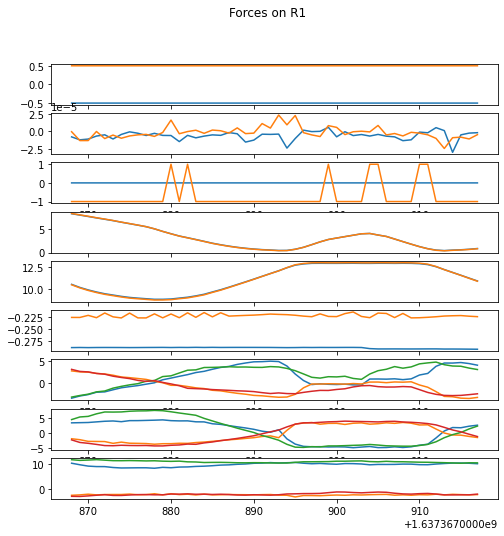

In [172]:
# Plotting only small segments of the predicted curve for actual visibility
exploratory_plot(5100,5150,df=linear_predicted_path)


In [175]:
means = []
individual_means = []
for f in ["fx_1", "fx_2", "fy_1", "fy_2", "fz_1", "fz_2"]:
    l = np.mean(np.square(linear_predicted_path[f] - linear_predicted_path["pred_"+f]))
    means.append(l)
    l = np.mean(np.square(linear_predicted_path[f] - linear_predicted_path["ind_pred_"+f]))
    individual_means.append(l)

print("Total Mean Squared Error of Single Prediction", np.mean(individual_means))
print("Total Mean Squared Error of Smoothed Prediction", np.mean(means))
    

Total Mean Squared Error of Single Prediction 5.478885924667254
Total Mean Squared Error of Smoothed Prediction 2.6176290509087656


## Smoothed Prediction Notes

The averaged predictions for each point in the path generally yields a smoother and more accurate curve.
